# Astrofísica Estelar – Tarea 3

Use the Milne equation to calculate the radiative flux spectrum at different depths in a gray model atmosphere.

## Python imports and setup

Mathematical functions from numpy and scipy

In [1]:
import numpy as np
from scipy.special import expn
from scipy.integrate import romberg, quad

Only deactivate warnings when we are sure that everything works correctly.

In [2]:
import warnings
warnings.filterwarnings('ignore')

Units and constants from astropy

In [3]:
import astropy.units as u
from astropy.constants import c, k_B, h, sigma_sb

Plotting with matplotlib and seaborn

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True)

## The gray atmosphere model

### Simplifying assumptions

* Fundamental "gray" assumption is that opacity is independent of frequency
* We assume radiative equilibrium, so that the frequency-integrated mean radiative intensity is equal to the source function: $J = S$. 
    * With further assumption of lane-parallel geometry, this means that frequency-integrated radiative flux, $H$, is constant with depth.
* We also assume *Local Thermodynamic Equilibrium* and no scattering, so that the source function at any frequency is given by the Planck function: $S_\nu = B_\nu$
* Furthermore, we use the *Eddington approximation*, $J = 3 K$, as a closure relation for the moments of the frequency-integrated radiative transfer equation. 

### Definitions

* Unique global parameter describing the atmosphere is effective temperature: $T_\mathrm{eff}$. 
* Dimensionless frequency: $\alpha = h\nu\, /\, kT_\mathrm{eff}$
* Eddington flux per dimensionless frequency: $H_{\alpha} = H_{\nu}\, d\nu/d\alpha$
* Reciprocal dimensionless temperature: $p(\tau) = T_\mathrm{eff} \,/\, T(\tau)$
* Frequency-integrated Planck function is  $B(\tau) = (\sigma/\pi) T(\tau)^4$

### Results from the gray atmosphere model

* Bolometric flux (constant with depth): $H = \sigma T_\mathrm{eff}^4 \,/\, 4 \pi$
* Frequency-integrated Source function, Planck function, and mean intensity: $S = B = J = 3 H (\tau + \frac{2}{3})$
* $\Rightarrow$ $B\big[\tau = \frac23\big] = B(T_\mathrm{eff}) = 4 H$

### Depth-variation of reciprocal temperature $p(\tau)$

From the above 
$$ \textstyle
(\sigma/\pi) T^4 = 3 (\sigma/4\pi) T_\mathrm{eff}^4 (\tau + \frac{2}{3}),
$$ 
which implies that
$$
p(\tau)^4 = \frac{4}{3\tau + 2}
$$
  

In [5]:
def p(tau):
    """T_eff / T as a function of `tau`"""
    return (4.0 / (3.0*tau + 2.0))**0.25

## Planck function

Frequency-resolved version: 
$$
B_\alpha = 
\frac{d\nu}{d\alpha} B_\nu =
\frac{k T_\mathrm{eff}}{h}
\frac{2 h }{c^2} 
\left(\frac{k T_\mathrm{eff}}{h}\right)^3
\frac{\alpha^3}{e^{\alpha p(\tau)} - 1}
= \frac{2 k^4 T_\mathrm{eff}^4}{h^3 c^2}
\frac{\alpha^3}{e^{\alpha p(\tau)} - 1}
$$

Normalization with respect to $B(T_\mathrm{eff})$:
$$
\frac{B_\alpha}{B(T_\mathrm{eff})} = \frac{C\, \alpha^3}{e^{\alpha p(\tau)} - 1}
$$
where the constant is
$$
C = \frac{2\pi k^{4}}{h^{3} c^{2} \sigma}.  
$$


In [6]:
bigC = 2*np.pi*k_B**4 / (h**3 * c**2 * sigma_sb)
bigC = bigC.value
print('C =', bigC)

C = 0.15398972357101687


Note that we use the `.value` method so that `bigC` is a float and not a `astropy.unit.Quantity`.  Otherwise, the integration functions become very slow.

In [7]:
def planck(alpha, tau):
    """Planck function normalized to unit area"""
    return bigC * alpha**3 / (np.exp(alpha*p(tau)) - 1.0)

### Plot the Planck function

Define fine grids in $\alpha$ and $\tau$ (`alpha_pts` and `tau_pts`), and also coarse grids (`alphas` and `taus`).

In [8]:
alpha_pts = np.linspace(0.0, 12.0, 200)
taus = [0.0, 1.0, 2.0, 4.0, 8.0]
alphas = [1.0, 3.0, 9.0]
tau_pts = np.linspace(0.0, 20.0, 200)
tau_label = r'Optical depth: $\tau$'
alpha_label = r'Frequency: $\alpha = h \nu / k T_\mathrm{eff}$'
planck_label = r'Planck function: $B_\alpha[T(\tau)] / B[T_\mathrm{eff}]$'

#### Plot $B_\alpha$ versus frequency for different depths

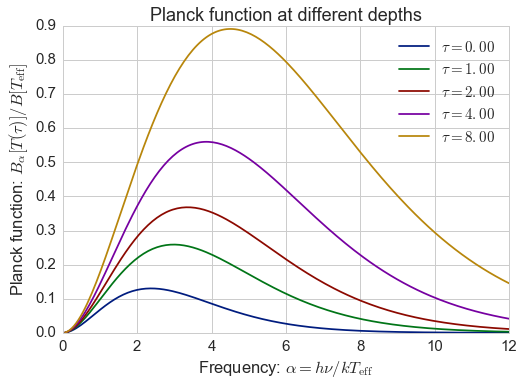

In [9]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function at different depths')
None

Note that magnitude and peak frequency of $B_\alpha$ both increase with $\tau$.  

In order to normalize the curves to the same area, we could plot $B_\alpha / B(T)$ instead of $B_\alpha / B(T_\mathrm{eff})$, so we multiply by $p(\tau)^4$:

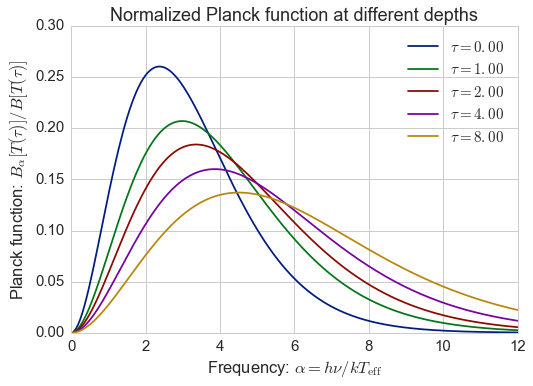

In [10]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = p(tau)**4 * planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label.replace(r'T_\mathrm{eff}', r'T(\tau)'))
ax.set_title('Normalized Planck function at different depths')
None

#### Plot $B_\alpha$ versus depths for different frequencies.

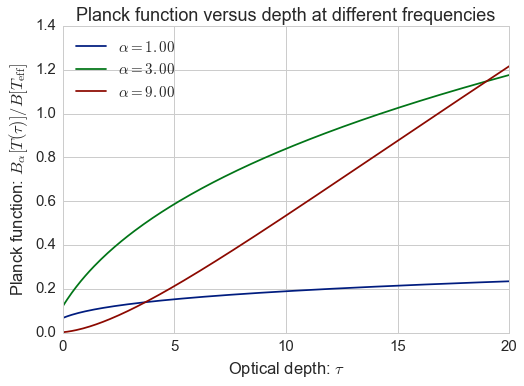

In [11]:
fig, ax = plt.subplots(1, 1)
for alpha in alphas:
    B = planck(alpha, tau_pts)
    ax.plot(tau_pts, B, label=r'$\alpha = {:.2f}$'.format(alpha))
ax.legend(loc='upper left')
ax.set_xlabel(tau_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function versus depth at different frequencies')
None

* On the Rayleigh-Jeans side ($\alpha = 1$), the Planck function grows only slowly with depth.
* Near the photospheric peak ($\alpha = 3$), the Planck function increases steeply for $\tau < 3$, but then levels off. 
* On the Wien side ($\alpha = 9$), the Planck function is low at the surface, but increases steeply at depth.

Zoom in on the range from $\tau = 0 \to 2$ and normalize by each frequency dependent $B_\alpha$ at $T = T_\mathrm{eff}$:

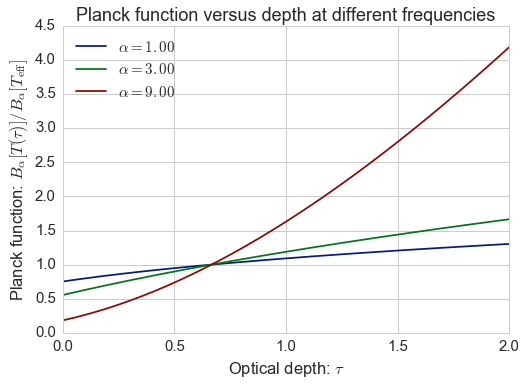

In [12]:
fig, ax = plt.subplots(1, 1)
for alpha in alphas:
    B = planck(alpha, tau_pts/10) / planck(alpha, 2./3.)
    ax.plot(tau_pts/10, B, label=r'$\alpha = {:.2f}$'.format(alpha))
ax.legend(loc='upper left')
ax.set_xlabel(tau_label)
ax.set_ylabel(planck_label.replace('B[', r'B_\alpha['))
ax.set_title('Planck function versus depth at different frequencies')
None

This shows more clearly that the gradient is much steeper at higher frequencies.

## Flux integral from Milne equation

General equation for flux is
$$
H_\nu(\tau) = \frac12 \left[
\int_{\tau}^{\infty} 
S_\nu(t)\, E_2(t - \tau) \, dt
\; -
\int_0^{\tau}
S_\nu(t)\, E_2(\tau - t) \, dt
\right]
$$
which in our case becomes
$$
H_{\alpha}(\tau) = \frac12 \left[
\int_{\tau}^{\infty} 
B_\alpha(t)\, E_2(t - \tau) \, dt
\; -
\int_0^{\tau}
B_\alpha(t)\, E_2(\tau - t) \, dt
\right]
$$

In which $B_\alpha = 4 H C \alpha^3 / (e^{\alpha p(\tau)} - 1)$ (see above).  So that
$$
\frac{H_{\alpha}(\tau)}{H} = 2 C \alpha^3
\left[ \int_{\tau}^{\infty} 
\frac{E_2(t - \tau) \, dt }{e^{\alpha p(t)} - 1} 
\; - 
\int_0^{\tau} 
\frac{E_2(\tau - t) \, dt }{e^{\alpha p(t)} - 1}
\right]
$$



### Define the integrand in the Milne equation

We write it as 
$$
2\, E_2(\vert t - \tau\vert) \, B_\alpha(t) \big/ B(T_\mathrm{eff})
$$
so that the constant $2 C$ is automatically included.

In [13]:
def milne_integrand(t, alpha, tau):
    """Second exponential integral times the source function"""
    return 2.0*expn(2, abs(t - tau))*planck(alpha, t)

### Perform the flux integrals

#### Negative contribution to flux from downward-moving photons

In [14]:
def downward(alpha, tau, integrand=milne_integrand):
    """Integrate the `integrand` between 0 and `tau` using quadpack"""
    result, error = quad(integrand, 0.0, tau, args=(alpha, tau))
    return result

#### Positive contribution to flux from upward-moving photons
Even though the upper limit is $t=\infty$, the `quad` routine from `scipy.integrate`, which is a wrapper for routines from the Fortran library QUADPACK, can still cope.

In [15]:
def upward(alpha, tau, integrand=milne_integrand):
    """Integrate the `integrand` between `tau` and infinity using quadpack"""
    result, error = quad(integrand, tau, np.infty, args=(alpha, tau))
    return result

#### Net flux is difference between upward and downward streams

Note that the integrations only work with scalar `alpha` and `tau`, so we use the `np.vectorize` function as a decorator to allow the `alpha` or `tau` arguments to be arrays.

In [16]:
@np.vectorize
def flux(alpha, tau):
    """Find net radiative flux as difference between 
    upward and downward streams"""
    rslt = upward(alpha, tau)
    if tau > 0.0:
        rslt -= downward(alpha, tau)
    return rslt

## Plot the fluxes

In [17]:
flux_label = r'Radiative flux: $H_\alpha(\tau) / H$'

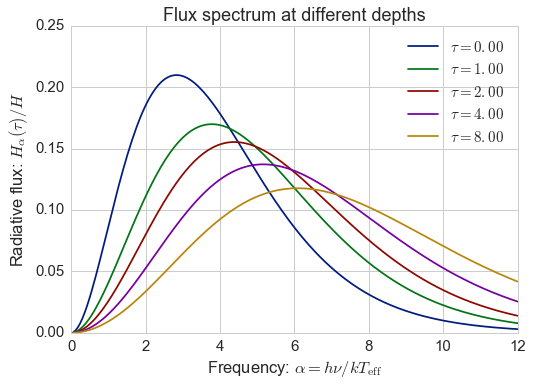

In [18]:
fig, ax = plt.subplots(1, 1)
Hlist = []
for tau in taus:
    H = flux(alpha_pts, tau)
    ax.plot(alpha_pts, H, label=r'$\tau = {:.2f}$'.format(tau))
    Hlist.append(H)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Flux spectrum at different depths')
None

Now we do the same, but also show the normalized Planck function.  Make use of the previous flux calculations, which we saved in `Hlist`.  Only show every other `tau` value for clarity.

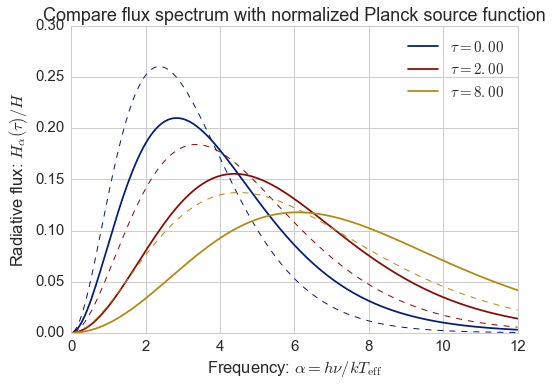

In [19]:
fig, ax = plt.subplots(1, 1)
colors = 'bry'
for tau, H, color in zip(taus[::2], Hlist[::2], colors):
    ax.plot(alpha_pts, H, c=color, 
            label=r'$\tau = {:.2f}$'.format(tau))
    B = p(tau)**4 * planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, lw=1, ls='--', c=color, label=None)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Compare flux spectrum with normalized Planck source function')
None

The flux spectrum (solid lines) is always shifted to higher frequencies than the local source function (dashed lines).  This is increasingly true at larger depths.  This is because the flux depends on the gradient of the source function, $d B_\nu / d \tau$, rather than on $B_\nu$ itself.

## The mean intensity

This is not part of the homework, but the mean intensity can be done in a similar way.


In [20]:
def schwarz_integrand(t, alpha, tau):
    """First exponential integral times source function"""
    return 2.0*expn(1, abs(t - tau))*planck(alpha, t)    

@np.vectorize
def meanJ(alpha, tau):
    """Mean intensity as sum of upward and downward streams"""
    rslt = upward(alpha, tau, integrand=schwarz_integrand)
    if tau > 0.0:
        rslt += downward(alpha, tau, integrand=schwarz_integrand)
    return rslt


### Plot the mean intensity

Unlike with the case of the flux, where the bolometric value is constant, the bolometric mean intensity increases with depth.

In [21]:
J_label = r'Mean intensity: $J_\alpha(\tau) / H$'

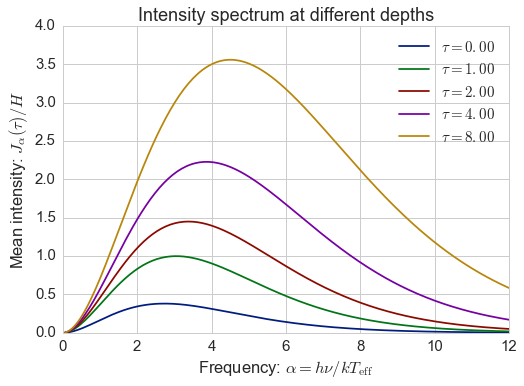

In [22]:
fig, ax = plt.subplots(1, 1)
Jlist = []
for tau in taus:
    J = meanJ(alpha_pts, tau)
    ax.plot(alpha_pts, J, label=r'$\tau = {:.2f}$'.format(tau))
    Jlist.append(J)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(J_label)
ax.set_title('Intensity spectrum at different depths')
None

Next, we compare it with the Planck source function.  We multiply by 4 so that it is normalized by $H$ rather than $B(T_\mathrm{eff})$.  

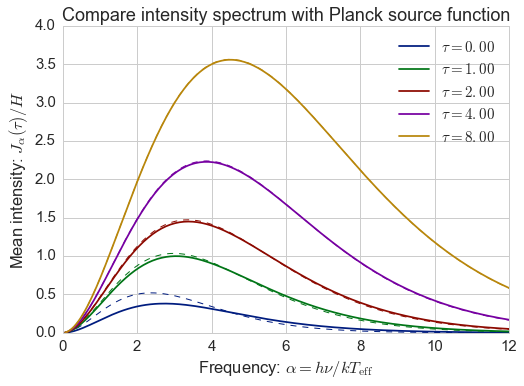

In [23]:
fig, ax = plt.subplots(1, 1)
colors = 'bgrmy'
for tau, J, color in zip(taus, Jlist, colors):
    ax.plot(alpha_pts, J, c=color, 
            label=r'$\tau = {:.2f}$'.format(tau))
    B = 4*planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, lw=1, ls='--', c=color, label=None)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(J_label)
ax.set_title('Compare intensity spectrum with Planck source function')
None

At the surface ($\tau = 0$) we have $J_\nu > B_\nu$ at high frequencies, but $J_\nu < B_\nu$ near the peak and at lower frequencies.  This is similar to the behavior of the flux at the surface. 

But at greater depths, the difference between $J_\nu$ and $B_\nu$ rapidly become very small, and are impossible to see on the graph for $\tau = 8$.

## Concentrate on $\tau = 0$

We normalize $J_\alpha$ and $B_\alpha$ by the surface value of the integrated Planck function $B(\tau\!=\!0) = \frac12 B(T_\mathrm{eff}) = 2 H$.

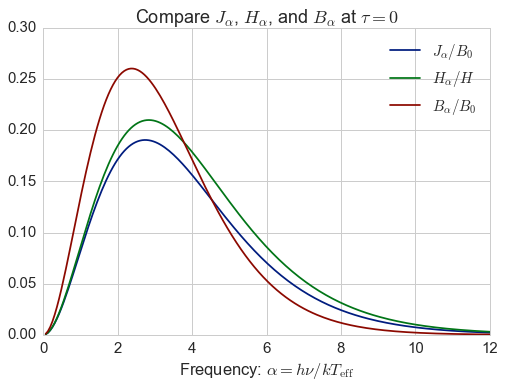

In [24]:
fig, ax = plt.subplots(1, 1)
J = Jlist[0]
H = Hlist[0]
B = 4*planck(alpha_pts, 0.0)
ax.plot(alpha_pts, J/2, label=r'$J_\alpha/B_0$')
ax.plot(alpha_pts, H, 
        label=r'$H_\alpha/H$')
ax.plot(alpha_pts, B/2, 
        label=r'$B_\alpha/B_0$')
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_title(r'Compare $J_\alpha$, $H_\alpha$, and $B_\alpha$ at $\tau = 0$')
None

Note that the flux spectrum $H_\alpha/H$ and the Planck function $B_\alpha/B_0$ are both normalized by their own frequency-integrated value, so the area under the curve is unity in both cases. 

On the other hand, the mean intensity spectrum is lower than these, which implies that $J < B$ at the surface.  This contradicts the assumption of radiative equilibrium and LTE, which imply $J = B$ everywhere.  **This is an intrinsic internal contradiction of the model, due to the fact that we have used the Eddington approximation instead of the exact solution to the gray problem.**. 

We can show this by analytically solving the Schwarzschild equation for the bolometric intensity, since the source function is linear in $\tau$.  Then, from Eq. (11.134) of Hubeny & Mihalas, one finds:
$$ \textstyle
J(\tau\!=\!0) = \frac12 S(\tau\!=\!\frac12) = 3H (\frac12 + \frac23) = \frac78 B(\tau\!=\!0)
$$

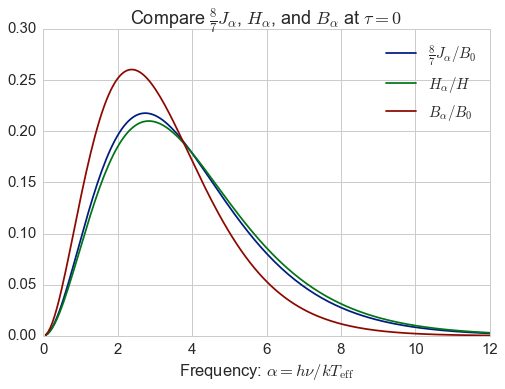

In [25]:
fig, ax = plt.subplots(1, 1)
J = Jlist[0]
H = Hlist[0]
B = 4*planck(alpha_pts, 0.0)
ax.plot(alpha_pts, (8.0/7.0)*J/2, label=r'$\frac{8}{7} J_\alpha/B_0$')
ax.plot(alpha_pts, H, 
        label=r'$H_\alpha/H$')
ax.plot(alpha_pts, B/2, 
        label=r'$B_\alpha/B_0$')
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_title(r'Compare $\frac{8}{7} J_\alpha$, $H_\alpha$, and $B_\alpha$ at $\tau = 0$')
None

So, multiplying the intensity by $\frac87$ allows one to more easily compare the shapes of the $J_\alpha$ and $H_\alpha$ curves.  The flux spectrum is slightly "hotter" than the intensity.